In [1]:
%load_ext autoreload
%autoreload 2

from typing import Any

import os
from os.path import join
import shutil
import random
from sklearn.model_selection import train_test_split

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch import nn
from torch.utils.data import Dataset, DataLoader

from settings import *
from validation_model import ValidationModel
import utils

In [2]:
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
samples = np.load('./new_smaples.npz')
# samples = np.load(SAMPLES_PATH)
samples = np.c_[samples["labels"], samples["faces"]]

In [4]:
face_train, face_test, label_train, label_test = train_test_split(
    samples[:, 1], samples[:, 0].astype(np.bool_), test_size=400
)

print("train size:", label_train.shape)
print("test size:", label_test.shape)

train size: (4335,)
test size: (400,)


## Train model

In [5]:
class FaceDataset(Dataset):
    def __init__(self, images: list, labels: list, device) -> None:
        super().__init__()

        self.images = images
        self.labels = labels
        self.device = device

        self.labels = torch.tensor(
            self.labels, dtype=torch.float, device=self.device
        ).unsqueeze(1)

    def __getitem__(self, index) -> Any:
        tensor_img = utils.file_to_tensor(self.images[index], self.device)

        return tensor_img, self.labels[index]

    def __len__(self):
        return len(self.labels)

In [77]:
# constants
LEARNING_RATE = 0.0001
BATCH_SIZE = 64

total_epochs = 0

train_ds = FaceDataset(face_train, label_train, DEVICE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = FaceDataset(face_test, label_test, DEVICE)
test_dl = DataLoader(test_ds, batch_size=len(label_test))

# model instance
model = ValidationModel().to(DEVICE)

# loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

train_loss, test_loss, train_acc, test_acc = [], [], [], []

In [86]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [87]:
# Training loop
for epoch in range(40):
    model.train()
    avg_loss = 0.0
    avg_acc = 0.0

    for batch_imgs, batch_labels in train_dl:
        optimizer.zero_grad()
        outputs = model(batch_imgs)
        loss = criterion(outputs, batch_labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # eval
        preds = outputs.detach().cpu().numpy() > 0.5
        labels = batch_labels.cpu().numpy()
        avg_acc += (preds == labels).mean()

        avg_loss += loss.item()

    train_acc.append(avg_acc / len(train_dl))
    avg_loss /= len(train_dl)
    train_loss.append(avg_loss)

    # test eval
    model.eval()
    with torch.no_grad():
        for batch_imgs, batch_labels in test_dl:
            # loss
            outputs = model(batch_imgs)
            loss = criterion(outputs, batch_labels)
            test_loss.append(loss.item())

            # accuracy
            preds = outputs.detach().cpu().numpy() > 0.5
            labels = batch_labels.cpu().numpy()
            accuracy = (preds == labels).mean()
            test_acc.append(accuracy)

    print_steps = 1
    if (epoch + 1) % print_steps == 0:
        print(
            f"[epoch {total_epochs+1:03d}] [loss {train_loss[-1]:.4f} | {test_loss[-1]:.4f}] [acc {train_acc[-1]:.4f} | {test_acc[-1]:.4f}]",
            end="\t",
        )
        if (epoch + 1) % (print_steps * 2) == 0:
            print()

    # save progress
    torch.save(model.state_dict(), f"./checkpoints_vm/epoch-{total_epochs + 1}.pth")

    total_epochs += 1

print("Training complete.")

[epoch 011] [loss 0.2150 | 0.2214] [acc 0.9248 | 0.9125]	[epoch 012] [loss 0.2103 | 0.2227] [acc 0.9257 | 0.9150]	
[epoch 013] [loss 0.2182 | 0.2234] [acc 0.9216 | 0.9150]	[epoch 014] [loss 0.2211 | 0.2227] [acc 0.9251 | 0.9150]	
[epoch 015] [loss 0.2143 | 0.2215] [acc 0.9223 | 0.9175]	[epoch 016] [loss 0.2152 | 0.2258] [acc 0.9225 | 0.9175]	
[epoch 017] [loss 0.2221 | 0.2248] [acc 0.9196 | 0.9200]	[epoch 018] [loss 0.2139 | 0.2220] [acc 0.9215 | 0.9175]	
[epoch 019] [loss 0.2144 | 0.2228] [acc 0.9215 | 0.9150]	[epoch 020] [loss 0.2113 | 0.2233] [acc 0.9215 | 0.9150]	
[epoch 021] [loss 0.2125 | 0.2220] [acc 0.9246 | 0.9150]	[epoch 022] [loss 0.2126 | 0.2229] [acc 0.9255 | 0.9150]	
[epoch 023] [loss 0.2163 | 0.2229] [acc 0.9210 | 0.9150]	[epoch 024] [loss 0.2138 | 0.2224] [acc 0.9235 | 0.9150]	
[epoch 025] [loss 0.2132 | 0.2251] [acc 0.9255 | 0.9200]	[epoch 026] [loss 0.2133 | 0.2217] [acc 0.9239 | 0.9150]	
[epoch 027] [loss 0.2119 | 0.2220] [acc 0.9228 | 0.9150]	[epoch 028] [loss 0.217

## Evaluation

In [88]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

f1 = f1_score(labels, preds)
precesion = precision_score(labels, preds)
recall = recall_score(labels, preds)
accuracy = accuracy_score(labels, preds)

print(f"f1: {f1:.4f} | precesion: {precesion:.4f} | recall: {recall:.4f} | accuracy: {accuracy:.4f}")

f1: 0.9331 | precesion: 0.9115 | recall: 0.9556 | accuracy: 0.9150


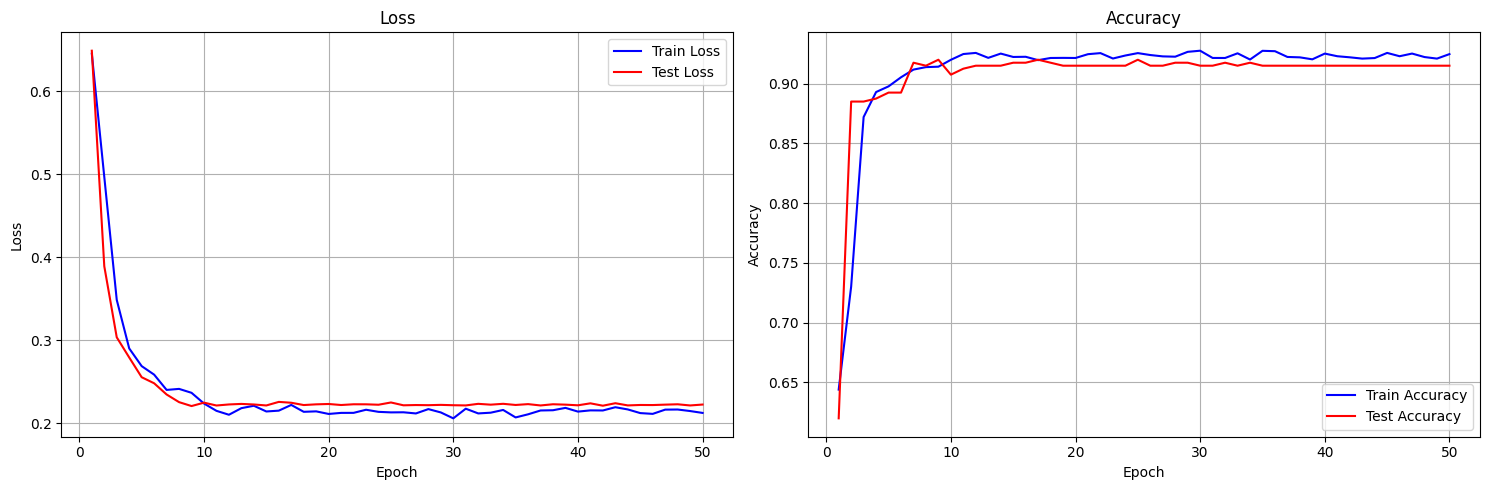

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax[0].plot(range(1, total_epochs + 1), train_loss, c='blue')
ax[0].plot(range(1, total_epochs + 1), test_loss, c='red')
ax[0].legend(["Train Loss", "Test Loss"])
ax[0].set_title("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid(True)

# Accuracy
ax[1].plot(range(1, total_epochs + 1), train_acc, c='blue')
ax[1].plot(range(1, total_epochs + 1), test_acc, c='red')
ax[1].legend(["Train Accuracy", "Test Accuracy"])
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True)

plt.tight_layout()
plt.show()


Run validation prediction on all faces

In [90]:
all_faces = os.listdir(FACE_DIR)
all_faces = [join(FACE_DIR, file) for file in all_faces]

preds = []

model.eval()

with torch.no_grad():
    for file_path in all_faces:
        img = utils.file_to_tensor(file_path).unsqueeze(0)
        y_pred = model(img).item()
        preds.append(y_pred)

preds = np.array(preds)

Visualizing the predictions

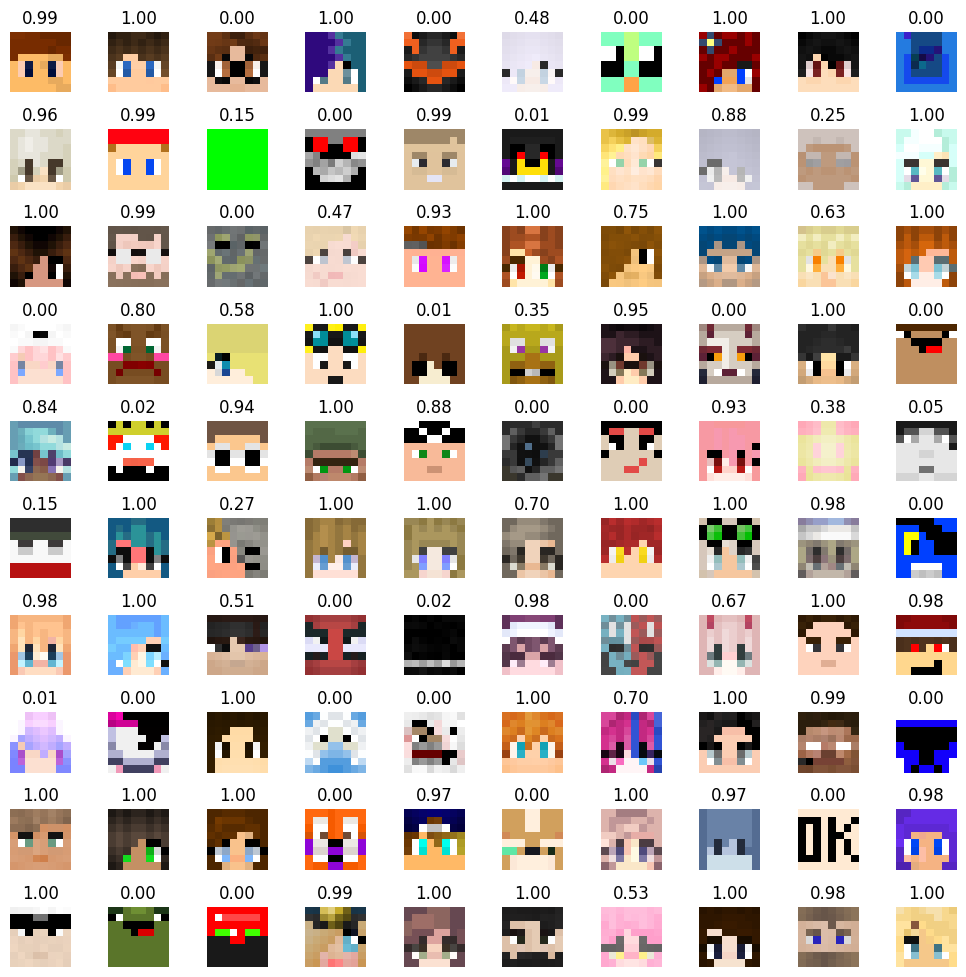

In [18]:
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

start_indx = 2100
for i in range(start_indx, start_indx + 100):
    lab_img = np.array(Image.open(all_faces[i]))

    spot = i - start_indx
    axs[spot // 10, spot % 10].imshow(lab_img)
    axs[spot // 10, spot % 10].axis("off")

    title = f"{preds[i]:.02f}"

    axs[spot // 10, spot % 10].set_title(title)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

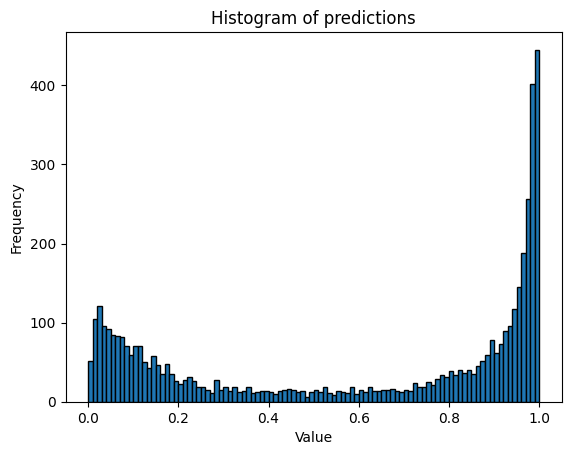

In [94]:
plt.hist(preds, bins=100, range=(0, 1), edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of predictions')
plt.show()

In [95]:
preds.max(), preds.min()

(0.9997956156730652, 0.0010516394395381212)

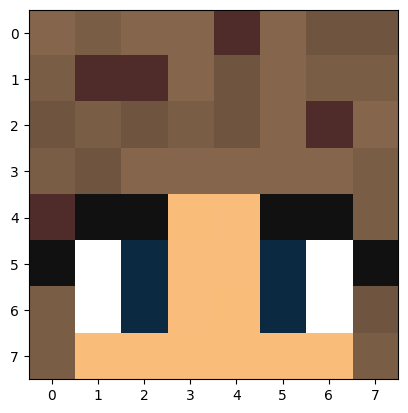

In [85]:
idx = np.where(preds == 0.9997718930244446)[0][0]
lab_img = np.array(Image.open(all_faces[idx]))
plt.imshow(lab_img)

## Saving

Save valid files

In [12]:
valid_face_indexes = np.array(np.where(preds > 0.7)).squeeze()

In [10]:
if not os.path.isdir(VALID_FACE_DIR):
    os.mkdir(VALID_FACE_DIR)

for valid_index in valid_face_indexes:
    file_name = all_faces[valid_index].split("/")[-1]
    new_path = join(VALID_FACE_DIR, file_name)
    shutil.copy(all_faces[valid_index], new_path)